# SPAM DETECTION SYSTEM

This project aims to build a spam detection system using Natural Language Processing (NLP) techniques in order to classify emails as spam or not spam based on the content of the email.
The steps involved in this project are:
1. Train a classifier to identify spam emails.
2. Find out the principal topics of the spam emails.
3. Compute the semantic similarity between the spam emails, to verify the etheroegeneity of the spam emails.
4. Extract from non-spam emails the Organisations mentioned in the emails.

In [1]:
import pandas as pd
import numpy as np
import models as md
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%config Completer.use_jedi=False

2024-07-16 19:14:03.436942: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-16 19:14:03.438682: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-16 19:14:03.463806: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-16 19:14:03.463835: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-16 19:14:03.464539: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

The dataset is available in data, and it is called `spam_dataset.csv`. It contains the following columns:

In [2]:
spam_df = pd.read_csv('../data/spam_dataset.csv', index_col=0)
spam_df.head(5)
print('------------------')
spam_df.shape
print('------------------')
spam_df.isnull().sum()
print('------------------')
spam_df['text'][605]
print('------------------')
spam_df.value_counts('label')

,label,text,label_num
605,ham,Subject: enron methanol ; meter # : 988291\nth...,0
2349,ham,"Subject: hpl nom for january 9 , 2001\n( see a...",0
3624,ham,"Subject: neon retreat\nho ho ho , we ' re arou...",0
4685,spam,"Subject: photoshop , windows , office . cheap ...",1
2030,ham,Subject: re : indian springs\nthis deal is to ...,0


------------------


(5171, 3)

------------------


label        0
text         0
label_num    0
dtype: int64

------------------


"Subject: enron methanol ; meter # : 988291\nthis is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary\nflow data provided by daren } .\nplease override pop ' s daily volume { presently zero } to reflect daily\nactivity you can obtain from gas control .\nthis change is needed asap for economics purposes ."

------------------


label
ham     3672
spam    1499
Name: count, dtype: int64

* *Label* column is the target variable and it is binary categorical. <br>
* *Text* column is the email content. <br>
* *Label_num* column is the target variable encoded as 0 for ham and 1 for spam. <br>

We can see the distribution of the target variable below.

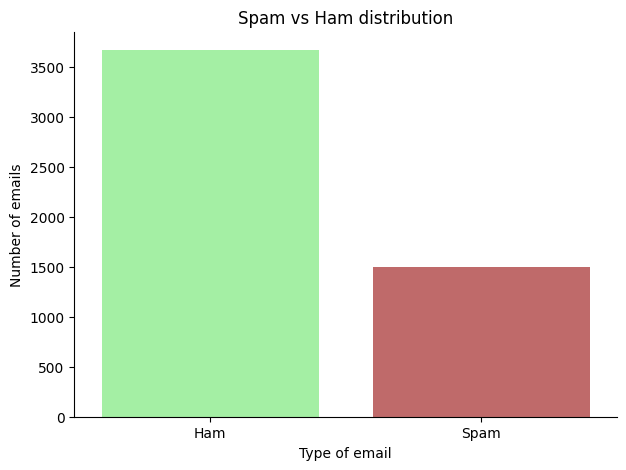

In [3]:
import plots as pl
pl.plot_spam_vs_ham(spam_df.value_counts('label'))

## Preprocessing
Let reset the dataframe indexes, and import the necessary libraries for removing the stopwords, punctuation, and lemmatizing the text.<br>
As in [toxic comments filter](https://github.com/EnricoMiche1210760/toxic_comments_filter) project, we will use the `nltk` library to remove the stopwords and punctuation, and to lemmatize the text, while we use spacy to extract the organisations from the non-spam emails and for word tokenization.

In [4]:
spam_df.reset_index(drop=True, inplace=True)
spam_df.head(3)

,label,text,label_num
0,ham,Subject: enron methanol ; meter # : 988291\nth...,0
1,ham,"Subject: hpl nom for january 9 , 2001\n( see a...",0
2,ham,"Subject: neon retreat\nho ho ho , we ' re arou...",0


In [5]:
import nltk
import spacy
import os

try:
    nlp = spacy.load('en_core_web_sm')
except:
    os.system('python -m spacy download en_core_web_sm')
    nlp = spacy.load('en_core_web_sm')
try:
    eng_stopwords = nltk.corpus.stopwords.words('english')
except:
    nltk.download('stopwords')
    eng_stopwords = nltk.corpus.stopwords.words('english')
try:
    _ = nltk.tokenize.word_tokenize('test')
except:
    nltk.download('punkt')


In [6]:
np.argmax([len(spam_df['text'][i]) for i in range(spam_df.shape[0])])
emails = spam_df['text'].values


949

In order to correctly preprocess the text, the following steps are performed:
1. Remove the stopwords and punctuation.
2. Lemmatize the text.
3. Tokenize the text.

The first two steps are performed in *preprocess_text_and_store* function, which preprocesses the text and stores the result into the desired file.

In [7]:
from preprocess import preprocess_text_and_store
preprocessed_text= preprocess_text_and_store(emails, doc_store="preprocessed_spam_df.csv", store=True)

Before computing the third step, we split the dataset into training, validation and test set. Since the dataset is quite small, we will use 65% of the data for training, 15% for validation and 20% for testing.
The dataset is imbalanced, but we will not balance it, since the imbalance is not too severe.

In [8]:
from preprocess import train_test_val_split
X_train, X_test, X_val, y_train, y_test, y_val = train_test_val_split(preprocessed_text, labels=spam_df['label_num'], test_size=0.2, val_size=0.15)

X_train[0:3]
y_train[0:3]

['dobmeos hgh energy level gone stukm introducing doctor formulated hgh human growth hormone also called hgh referred medical science master hormone plentiful young near age twenty one bodies begin produce less time forty nearly everyone deficient hgh eighty production normally diminished least advantages hgh increased muscle strength loss body fat increased bone density lower blood pressure quickens wound healing reduces cellulite improved vision wrinkle disappearance increased skin thickness texture increased energy levels improved sleep emotional stability improved memory mental alertness increased sexual potency resistance common illness strengthened heart muscle controlled cholesterol controlled mood swings new hair growth color restore read website unsubscribe',
 'nan',
 'enron actuals dec dec teco tap enron hpl gas daily lsp hpl katy enron']

array([1, 1, 0])

We can proceed with the tokenization of the text. We use 'Tokenizer' class from keras to tokenize the text, setting the maximum number of words to 1500; then we set the maximum length of the sequences by finding the maximum length of the sequences in the training set. We finally pad the sequences to have the same length.
The choice of using this strategy instead of computing the tf-idf matrix is due to the fact that the want to use the word embeddings to represent the text, and the word embeddings are learned during the training of the model.<br>
This strategy helps to import a pre-trained model, **lstm_cnn_model.keras**, which is a model that combines a Convolutional Neural Network (CNN) and a Long Short-Term Memory (LSTM), and it has been trained in the [toxic comments filter](https://github.com/EnricoMiche1210760/toxic_comments_filter).

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=1500)
tokenizer.fit_on_texts(X_train)

tokenizer.word_counts

OrderedDict([('dobmeos', 1),
             ('hgh', 10),
             ('energy', 498),
             ('level', 63),
             ('gone', 23),
             ('stukm', 1),
             ('introducing', 8),
             ('doctor', 47),
             ('formulated', 4),
             ('human', 18),
             ('growth', 77),
             ('hormone', 7),
             ('also', 484),
             ('called', 112),
             ('referred', 5),
             ('medical', 53),
             ('science', 8),
             ('master', 25),
             ('plentiful', 1),
             ('young', 161),
             ('near', 46),
             ('age', 48),
             ('twenty', 15),
             ('one', 576),
             ('bodies', 5),
             ('begin', 67),
             ('produce', 12),
             ('less', 225),
             ('time', 628),
             ('forty', 8),
             ('nearly', 14),
             ('everyone', 95),
             ('deficient', 1),
             ('eighty', 3),
             ('produ

In [10]:
X_train_padded = tokenizer.texts_to_sequences(X_train)
X_test_padded = tokenizer.texts_to_sequences(X_test)
X_val_padded = tokenizer.texts_to_sequences(X_val)

vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary size: ", vocab_size)

Vocabulary size:  35469


We set the padding type to 'pre' in order to keep the most important information at the end of the sequences. This strategy is useful since the spam emails are usually short and the spam content is at the end of the email.

In [11]:
maxlen = len(max(X_train_padded, key=len))
X_train_padded = pad_sequences(X_train_padded, padding='pre', maxlen=maxlen)
X_test_padded = pad_sequences(X_test_padded, padding='pre', maxlen=maxlen)
X_val_padded = pad_sequences(X_val_padded, padding='pre', maxlen=maxlen)

In [12]:
X_train_padded[0:5]
X_train_padded.shape
y_train.shape

array([[   0,    0,    0, ...,  373,  469,  536],
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    9,  516,    3],
       [   0,    0,    0, ..., 1379,  259,   31],
       [   0,    0,    0, ...,  352,  605,  178]], dtype=int32)

(3360, 1529)

(3360,)

We finally obtain a training set of shape (3360, 1529).

## Predicting spam emails

In order to predict the spam emails, we create two different models, both based on neural networks. <br>
The first model is based on the pre-trained model **lstm_cnn_model.keras**, which is imported and trained on the training set. The model was initially trained to recognize the toxicity of a comment according to 6 different categories. To adapt the model to the spam detection task, we added an *input layer* with the shape of the sequences, and an *output layer* with a **sigmoid activation function**, since the task is binary classification.<br>
The choice of using this model is due to the fact that the model has already learned the word embeddings, and it has been trained on a similar task, so it should be able to recognize the spam emails. Precisely because of this similarity, we thought it was the best time to test reinforced learning.<br>
<br>
The second model is a **GRU model**, which is a simpler model than the first one, but it is still able to recognize the spam emails. The model is composed of an embedding layer, a GRU layer, and a dense layer with a sigmoid activation function. 
We pick the GRU model as a comparison to the first model, to see if a simpler model can achieve similar results. Moreover GRU is faster to train than LSTM, so it is useful to test the model on a smaller dataset.

In [13]:
import tensorflow as tf
early_stopping = md.EarlyStopping(5)

In [14]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.backend import clear_session
from models import GRU_model, weighted_binary_crossentropy

The first model, requires to use a weighted binary crossentropy loss function. We already said that the dataset is imbalanced, but the imbalance is not severe.<br>
Defining the weights for the loss function is useful to give more importance to the minority class, in this case the spam emails. The weights are calculated as follows:
$$
w_{0} = \frac{N}{2 \cdot \text{count}_{0}}
$$
$$
w_{1} = \frac{N}{2 \cdot \text{count}_{1}}
$$
where $N$ is the number of labels, and $\text{count}$ is the number of occurrences of the label in the dataset. 

In [15]:
clear_session()
w0 = [(1/np.sum(y_train == 0)) * (len(y_train) /2)]
w1 = [(1/np.sum(y_train == 1)) * (len(y_train) /2)] 
w0, w1

([0.7055858882822343], [1.7160367722165475])

Then the loss function is defined as:

$$
\text{L}_{w} = -\text{E} \left[ w_{0} \cdot y \cdot \log(p) + w_{1} \cdot (1 - y) \cdot \log(1 - p) \right]
$$
<br>

where $y$ is the true label, $p$ is the predicted label, and $\text{E}$ is the expectation (see *models.py*).

In [16]:
reinforced_model = "reinforced_lstm.keras"
tf_to_do = True
if reinforced_model in os.listdir('../models'):
    lstm_cnn_model = load_model("../models/"+reinforced_model, custom_objects={'loss': weighted_binary_crossentropy(w0, w1)})
    tf_to_do = False
else:                       
    lstm_cnn_model_keras = "lstm_cnn_model.keras"
    custom_objects = {'loss': weighted_binary_crossentropy(w0, w1)}
    transfer_learning_model = load_model("../models/"+lstm_cnn_model_keras, custom_objects=custom_objects, )

In [17]:
if tf_to_do:
    transfer_learning_model.summary()

In [18]:
if tf_to_do:
    new_input = Input(shape=(maxlen,))
    transfer_learning_model.summary()
    output = transfer_learning_model.layers[0](new_input)
    for i in range(1, len(transfer_learning_model.layers)):
        output = transfer_learning_model.layers[i](output)
    output = Dense(1, activation='sigmoid', name='output')(output)
    lstm_cnn_model = Model(new_input, output)

Here we can see the summary of the first model:

In [19]:
lstm_cnn_model.compile(optimizer='adam', loss=weighted_binary_crossentropy(w0, w1), metrics=['accuracy'])
lstm_cnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1529)]            0         
                                                                 
 embedding (Embedding)       (None, 1529, 150)         13954350  
                                                                 
 dropout (Dropout)           (None, 1529, 150)         0         
                                                                 
 bidirectional (Bidirection  (None, 1529, 200)         200800    
 al)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 1529, 200)         0         
                                                                 
 conv1d (Conv1D)             (None, 1525, 64)          64064     
                                                             

In [20]:
if tf_to_do:
    lstm_cnn_model.fit(X_train_padded, 
        y_train, 
        epochs=10, 
        validation_data=(X_val_padded, y_val), 
        batch_size=32, 
        callbacks=[early_stopping])
    lstm_cnn_model.save("../models/reinforced_lstm.keras")

In [21]:
clear_session()

While here we can see the summary of the second model:

In [22]:
gru_model_name = "gru_model.keras"
if gru_model_name in os.listdir('../models'):
        gru_model = load_model("../models/"+gru_model_name)
        gru_model.summary()
        gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

else:
        gru_model = GRU_model(vocab_size=vocab_size, maxlen=maxlen, activation='sigmoid')
        gru_model.summary()
        gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        gru_model.fit(X_train_padded, 
                y_train, 
                epochs=10, 
                validation_data=(X_val_padded, y_val), 
                batch_size=32, 
                callbacks=[early_stopping])

        gru_model.save("../models/"+gru_model_name)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1529, 256)         9080064   
                                                                 
 gru (GRU)                   (None, 128)               148224    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 9228417 (35.20 MB)
Trainable params: 9228417 (35.20 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
y_pred = gru_model.predict(X_test_padded)

33/33 [==============================] - 7s 208ms/step


In [24]:
y_pred_cnn_lstm = lstm_cnn_model.predict(X_test_padded)

33/33 [==============================] - 11s 326ms/step


After the training of the models, we can see the results of the models on the test set. The first model (reinforced LSTM with CNN) has a recall on the spam class of 0.97, while the second model has a recall on the spam class of 0.92. The first model has a slightly better performance than the second model, but the difference is not significant, as reported by the f1-score.<br>
The confusion matrices below help us to understand the performance of the models.<br>
Since recall is better for the LSTM model, we choose this model as the best model for the spam detection task.

GRU model report:
		precision    recall  f1-score   support
           0       0.97      0.98      0.98       742
           1       0.95      0.92      0.94       293
	-------------------------------------------------


LSTM (reinforced) model report:
		precision    recall  f1-score   support
           0       0.99      0.97      0.98       742
           1       0.93      0.97      0.95       293
	-------------------------------------------------


GRU Model Confusion Matrix


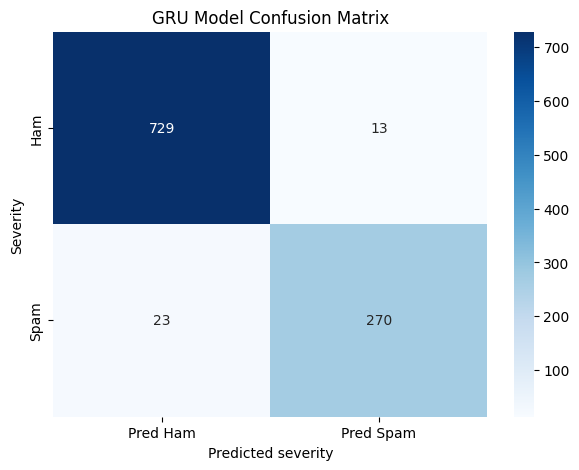

Reinforced LSTM Model Confusion Matrix


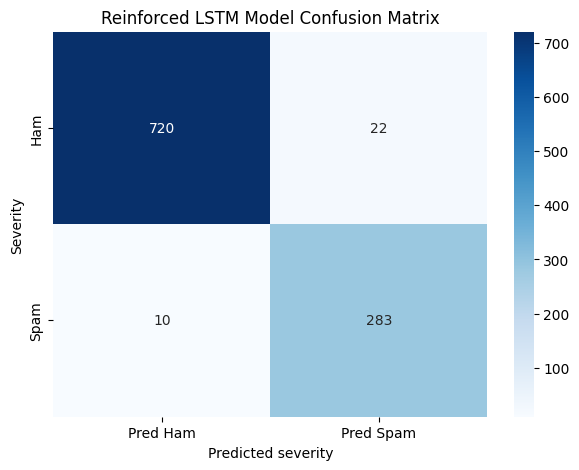

In [25]:
from sklearn.metrics import classification_report
from plots import print_confusion_matrix, print_table_from_classification_report

print_table_from_classification_report("GRU model report:", classification_report(y_test, np.round(y_pred)))
print_table_from_classification_report("LSTM (reinforced) model report:", classification_report(y_test, np.round(y_pred_cnn_lstm)))
print_confusion_matrix(y_test, np.round(y_pred), "GRU Model Confusion Matrix")
print_confusion_matrix(y_test, np.round(y_pred_cnn_lstm), "Reinforced LSTM Model Confusion Matrix")

In [26]:
y_pred_cnn_lstm = np.round(y_pred_cnn_lstm)

## Topic extraction

The second part of the project consists in finding the principal topics of the spam emails. We use the Latent Dirichlet Allocation (LDA) algorithm to extract the topics from the spam emails. The LDA algorithm is a generative probabilistic model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar. The algorithm is based on the assumption that the documents are a mixture of a small number of topics, and that each word's presence is attributable to one of the document's topics. The algorithm is based on the Dirichlet distribution, which is a distribution over distributions. The algorithm is based on the following steps:
1. Initialize the topic distribution for each word in each document.
2. Iterate over the documents and the words in the documents, and update the topic distribution for each word.
3. Iterate over the topics and the words in the topics, and update the topic distribution for each topic.
4. Iterate over the documents and the words in the documents, and update the topic distribution for each document.

The algorithm is based on the following formulas:
$$
p(z_{d,n} = k | z_{-d,n}, w) \propto \frac{n_{d,k} + \alpha}{n_{d} - 1 + K \cdot \alpha} \cdot \frac{v_{k,w} + \beta}{v_{k} + W \cdot \beta}
$$

where $z_{d,n}$ is the topic of the $n$-th word in the $d$-th document, $n_{d,k}$ is the number of words in the $d$-th document assigned to the $k$-th topic, $n_{d}$ is the number of words in the $d$-th document, $v_{k,w}$ is the number of times the word $w$ has been assigned to the $k$-th topic, $v_{k}$ is the number of words assigned to the $k$-th topic, $K$ is the number of topics, $W$ is the number of words in the vocabulary, $\alpha$ is the Dirichlet parameter for the document-topic distribution, and $\beta$ is the Dirichlet parameter for the topic-word distribution.

### Word Clouds
Before going deep with the LDA algorithm, we create word clouds for the ham and spam emails, in order to have a visual representation of the most frequent words in the emails. The word clouds are created using the `WordCloud` class from the `wordcloud` library.

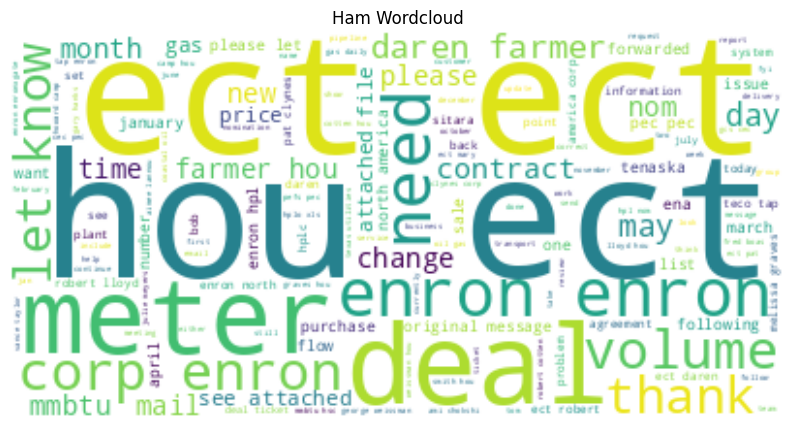

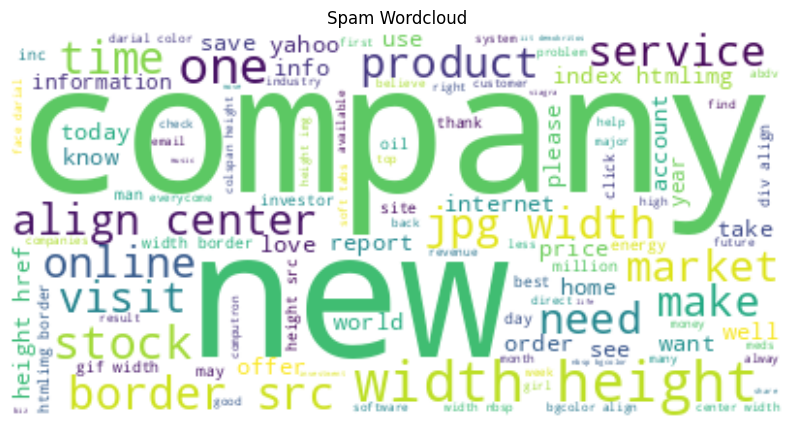

In [27]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

ham_text = " ".join(X_test[idx] for idx in np.where(y_pred_cnn_lstm == 0)[0])
pl.show_wordcloud(ham_text, "Ham Wordcloud")

spam_text = " ".join(X_test[idx] for idx in np.where(y_pred_cnn_lstm == 1)[0])
pl.show_wordcloud(spam_text, "Spam Wordcloud")

### Clustering of spam emails

The principal idea to identify the main topics, is to cluster the spam emails using the KMeans algorithm. The KMeans algorithm is an unsupervised algorithm that aims to partition the data into $K$ clusters, where each data point belongs to the cluster with the nearest mean. The algorithm is based on the following steps:
1. Initialize the centroids of the clusters.
2. Assign each data point to the nearest centroid.
3. Update the centroids of the clusters.
4. Repeat steps 2 and 3 until convergence.

The algorithm is based on the following formulas:
$$
\text{argmin}_{c} \sum_{i=1}^{n} \left| x_{i} - c \right|^{2}
$$

where $x_{i}$ is the $i$-th data point, and $c$ is the centroid of the cluster.

The choice of the number of clusters is then performed using the elbow method, which consists in plotting the sum of the squared distances of the data points to the nearest centroid for different values of $K$, and then choosing the value of $K$ where the curve starts to flatten.

We restart from the preprocessed text, without the tokenization, and we use the `TfidfVectorizer` class from the `sklearn` library to compute the tf-idf matrix of the spam emails. The tf-idf matrix is a matrix where the rows are the documents, the columns are the words in the vocabulary, and the values are the tf-idf values of the words in the documents. The tf-idf values are computed as follows:
$$
\text{tf-idf}(w, d) = \text{tf}(w, d) \cdot \text{idf}(w)
$$

where $\text{tf}(w, d)$ is the term frequency of the word $w$ in the document $d$, and $\text{idf}(w)$ is the inverse document frequency of the word $w$ in the documents.<br>
The vectorization is a necessary step to compute the cosine similarity between the spam emails.

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

spam_text = preprocessed_text[spam_df[spam_df['label_num'] == 1].index[:]]
list_spam_text = [str(text) for text in spam_text] 
tfidf = TfidfVectorizer()

spam_tfidf = tfidf.fit_transform(list_spam_text)

In [29]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
def compute_inertia_with_kmeans_pp(data):
    sse = {}

    for k in range(1, 11):
        kmeans = KMeans(init="k-means++", n_clusters=k)
        kmeans.fit(data)
        sse[k] = kmeans.inertia_
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()), marker="o")
    plt.show()

Moreover for representing the results of the clustering, we use the Principal Component Analysis (PCA) algorithm to reduce the dimensionality of the tf-idf matrix. The PCA algorithm is an unsupervised algorithm that aims to find the principal components of the data, which are the directions along which the data varies the most. We set the number of components to 3, in order to plot the data in a 3D space.

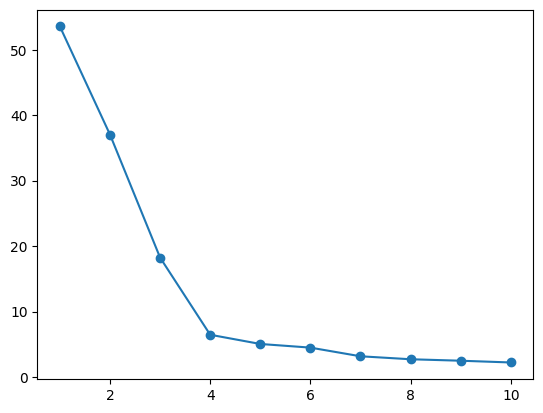

In [30]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3, random_state=7)
X_3d = pca.fit_transform(spam_tfidf)

compute_inertia_with_kmeans_pp(X_3d)

From the upper graph, we can see that the optimal number of clusters should be one between 4 and 5. We choose 5 as the number of clusters, and we proceed with the clustering of the spam emails.<br>
In the graph below, we can see the clustering of the spam emails in a 3D space. The emails are well separated, and the clusters are well defined.<br>
A cluster contains emails that are similar to each other, and different from the emails in the other clusters. The clustering is useful to identify the main topics of the spam emails.

In [31]:
from plots import plot_scatter_3D
%matplotlib inline
RANDOM_SEED = 0
n_clusters = 5
kmeans = KMeans(init="k-means++", n_clusters=n_clusters, random_state=RANDOM_SEED)
kmeans.fit(X_3d)
test_cluster = kmeans.labels_
centers = kmeans.cluster_centers_
y_kmeans = kmeans.predict(X_3d)
L = {x : f"Cluster n. {x+1}" for x in range(n_clusters)}
dict_X = {'x' : X_3d[:,0], 'y' : X_3d[:,1], 'z' : X_3d[:,2]}

plot_scatter_3D(dict_X, L, y_kmeans, kmeans.cluster_centers_, point_size = 5)

KMeans(n_clusters=5, random_state=0)

Once separeted the emails in clusters, we can extract the principal topics of the spam emails. <br>
We can finally use the LDA algorithm described above to extract the topics from the spam emails, and we set the number of topics to 5, since we have 5 clusters.
Before computing the LDA we create the dictionary and the corpus of the spam emails.<br>
In particular, the corpus is extracted using the Bag of Words model, which is a model that represents the documents as a bag of words, without considering the order of the words in the documents. <br>
From dictionary we filter out the words that appear in less than 5 documents, and in more than 95% of the documents. This ensures that the words are not too rare, and not too common.

In [32]:
import gensim.corpora as corpora
from gensim.models import LdaMulticore

spam_text = [str(text).split() for text in spam_text]

dictionary = corpora.Dictionary(spam_text)

len(dictionary)

dictionary.filter_extremes(no_below=5, no_above=0.95)

len(dictionary)

corpus = [dictionary.doc2bow(text) for text in spam_text]


lda_model = LdaMulticore(corpus=corpus,
                        id2word=dictionary,
                        num_topics=n_clusters,
                        random_state=100,
                        passes=10)


topics = lda_model.print_topics(num_words=10)
topics

36533

4114

[(0,
  '0.014*"http" + 0.011*"com" + 0.011*"get" + 0.006*"online" + 0.006*"new" + 0.006*"www" + 0.005*"time" + 0.005*"best" + 0.005*"one" + 0.005*"cialis"'),
 (1,
  '0.014*"pills" + 0.009*"money" + 0.009*"account" + 0.007*"please" + 0.005*"email" + 0.004*"com" + 0.004*"business" + 0.004*"bank" + 0.004*"million" + 0.004*"free"'),
 (2,
  '0.048*"font" + 0.040*"http" + 0.036*"height" + 0.031*"width" + 0.024*"size" + 0.023*"align" + 0.020*"border" + 0.019*"com" + 0.019*"www" + 0.018*"href"'),
 (3,
  '0.015*"company" + 0.011*"statements" + 0.008*"information" + 0.008*"may" + 0.007*"com" + 0.006*"report" + 0.006*"within" + 0.006*"stock" + 0.006*"securities" + 0.006*"investment"'),
 (4,
  '0.021*"nbsp" + 0.011*"windows" + 0.010*"price" + 0.010*"adobe" + 0.009*"email" + 0.009*"com" + 0.008*"software" + 0.007*"professional" + 0.007*"office" + 0.007*"new"')]

Above we can see the topics extracted from the spam emails. The topics are represented as a list of words, and each word has a weight that represents the importance of the word in the topic. The topics are well defined, and they represent the main topics of the spam emails.
A more exaustive explanation and visualization of the topics can be found below. We exploit the `pyLDAvis` library to visualize the topics extracted from the spam emails.
The representation we obtaine is a graph where the topics are represented as circles, and the words are represented as bars. The size of the circles represents the importance of the topics, while the size of the bars represents the importance of the words in the topics. The distance between the circles represents the similarity between the topics, meaning that the topics that are close to each other are similar to each other.<br>

The slider on the right allows to change the relevance of the words in the topics.
In particular the formula used to compute the relevance of the words is:
$$
\text{relevance}(w, k) = \lambda \cdot \log \left( \frac{p(w|k)}{p(w)} \right) + (1 - \lambda) \cdot \log \left( \frac{p(k|w)}{p(k)} \right)
$$

where $w$ is the word, $k$ is the topic, $p(w|k)$ is the probability of the word given the topic, $p(w)$ is the probability of the word, $p(k|w)$ is the probability of the topic given the word, $p(k)$ is the probability of the topic, and $\lambda$ is a parameter that balances the two terms.<br>
This formula explains the importance of the words in the topics, and the importance of the topics in the words.

In [33]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()
lda_display = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False)
pyLDAvis.save_html(lda_display, "../data/lda_5_clusters.html")
pyLDAvis.display(lda_display)

Let verify if 5 topics are enough to cluster the spam emails, measuring the coherence of the topics, computing the coherence score of the topics, varying the number of topics from 2 to 10. To do this, we use the `CoherenceModel` class from the `gensim` library, which computes the coherence score of the topics. The coherence score is a measure of the interpretability of the topics, and it is based on the pointwise mutual information of the words in the topics. The coherence score is computed as follows:
$$
\text{coherence} = \frac{1}{T} \sum_{t=1}^{T} \sum_{i=1}^{N_{t} - 1} \sum_{j=i+1}^{N_{t}} \text{PMI}(w_{i}, w_{j})
$$

where $T$ is the number of topics, $N_{t}$ is the number of words in the $t$-th topic, $w_{i}$ is the $i$-th word in the $t$-th topic, $w_{j}$ is the $j$-th word in the $t$-th topic, and $\text{PMI}$ is the pointwise mutual information of the words.
The  $\text{PMI}$ is calculated in turn as follows:
$$
\text{PMI}(w_{i}, w_{j}) = \log \left( \frac{p(w_{i}, w_{j})}{p(w_{i}) \cdot p(w_{j})} \right)
$$

where $p(w_{i}, w_{j})$ is the probability of the co-occurrence of the words $w_{i}$ and $w_{j}$, $p(w_{i})$ is the probability of the word $w_{i}$, and $p(w_{j})$ is the probability of the word $w_{j}$.

These formulas are extracted from the original paper ["Exploring the Space of Topic Coherence Measures"](http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf) of the coherence score.

In [34]:
from gensim.models import CoherenceModel

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, random_state=100, passes=10)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    return model_list, coherence_values


model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=spam_text, start=2, limit=10, step=1)
coherence_values


[0.5156019374930101,
 0.5554519204694772,
 0.49727965799204044,
 0.5579913483569705,
 0.4654698635235716,
 0.5731948030123165,
 0.4709017240952841,
 0.4857888170969149]

The results indicate that the score is higher for 7 topics, so we can consider to increase the number of topics to 7, and let see what happens.

In [35]:
pyLDAvis.enable_notebook()
lda_display = gensimvis.prepare(model_list[5], corpus, dictionary, sort_topics=False)
pyLDAvis.save_html(lda_display, "../data/lda_7_clusters.html")
pyLDAvis.display(lda_display)

The result of the LDA model for 7 topics shows an higher similarity between the topics. The coherence score is higher for 7 topics, but the topics are not well defined, so we can consider to keep the number of topics to 5.

## Organisations mentioned in non-spam emails
One last task is to extract the organisations mentioned in the non-spam emails. We use the `spacy` library to extract the named entities from the non-spam emails, and we filter out the named entities that are not organisations. The named entities are filtered out using the `ent_type_` attribute of the named entities, which contains the type of the named entity. The named entities that are organisations are then stored into a set, in order to avoid duplicates.
The algorithm used for this purpose is the Named Entity Recognition (NER) algorithm, which is an algorithm that aims to recognize the named entities in the text, and to classify them into different categories, such as persons, organizations, locations, dates, etc.

In [36]:
ham_text = preprocessed_text[spam_df[spam_df['label_num'] == 0].index[:]]
list_ham_text = [str(text) for text in ham_text]

In [37]:
def find_organization_names(text):
    organizations_docs = {}
    for doc in text:
        organizations_docs[doc] = set()
        nlp_doc = nlp(doc)
        for word in nlp_doc:
            if word.ent_type_ == 'ORG':
                organizations_docs[doc].add(str(word))
    return organizations_docs

organizations = find_organization_names(ham_text)

3171

Let see the organisations mentioned in the first 10 non-spam emails.

In [1]:
for i, doc in enumerate(organizations):
    counter = len(organizations[doc])
    if counter > 0:
        print('\n')
        print(f"In email: \"{doc}\"\nwe have found {counter} organizations, which are:")
        print('\033[94m' + "\n".join(map(str, organizations[doc])) + '\x1b[0m')
        print('------------------')
    if i == 9:
        break


NameError: name 'organizations' is not defined

## Conclusion
In this project we built a spam detection system using Natural Language Processing (NLP) techniques. We trained a classifier to identify spam emails, and we found out the principal topics of the spam emails. We computed the semantic similarity between the spam emails, and we extracted from non-spam emails the organisations mentioned in the emails.